# Introduction

The last 50 years indicate that artificial intelligence (AI) algorithms will be incorporated into more and more everyday applications. For example, we might want to include an image classifier in a smart phone app. To do this, we'd use a deep learning model trained on hundreds of thousands of images as part of the overall application architecture. A large part of software development in the future will be using these types of models as common parts of applications. 

In this project, I am going to train an image classifier to recognize _different species of flowers_. We can imagine using something like this in a mobile app that tells us the name of the flower our camera is pointing at. In practice, we would train this classifier, then export it for use in our application. I will be using the [102 Category Flower Dataset](http://www.robots.ox.ac.uk/~vgg/data/flowers/102/index.html) from the [Visual Geometry Group](http://www.robots.ox.ac.uk/~vgg/) of the [University of Oxford](http://www.ox.ac.uk/). You can see a few examples below. 

![title](images/flowers.png)

The project is broken down into multiple steps:

* Load and preprocess the image dataset.
* Train the image classifier on our dataset.
* Use the trained classifier to predict image content.

When I complete this project, I will have an application that can be trained on _any_ set of labeled images. I will also turn it into a __command line application__.

# Part 1: Importing Libraries

In [1]:
# The libraries that we will need
import json
import torch
import argparse
import numpy as np
from torch import nn, optim
from torchvision import datasets, transforms, models
import torch.nn.functional as F
from PIL import Image

# Part 2: Importing Dataset

Here I will use `torchvision` to load the data. You might want to refer to the [documentation](http://pytorch.org/docs/0.3.0/torchvision/index.html). Note that the data __must__ be included alongside this notebook, otherwise you might run into problems. You can download the dataset (329 MB) by simply clicking [here](https://s3.amazonaws.com/content.udacity-data.com/nd089/flower_data.tar.gz). The dataset is split into three parts: training, validation, and testing. For the training, I am going to apply transformations such as random scaling, cropping, and flipping. This will help the network generalize leading to better performance. You'll also need to make sure the input data is resized to 224x224 pixels as required by the pre-trained networks.

The validation and testing sets are used to measure the model's performance on data it hasn't seen yet. For this we don't want any scaling or rotation transformations, but you'll need to resize then crop the images to the appropriate size.

The pre-trained networks we will be using were trained on the `ImageNet` dataset where each color channel was normalized separately. For all three sets we'll need to normalize the means and standard deviations of the images to what the network expects. For the means, it's `[0.485, 0.456, 0.406]` and for the standard deviations `[0.229, 0.224, 0.225]`, calculated from the `ImageNet` images. These values will shift each color channel to be centered at 0 and range from -1 to 1.

In [2]:
data_dir = "flowers"
train_dir = data_dir + "/train"
valid_dir = data_dir + "/valid"
test_dir = data_dir + "/test"

## 2.1. Transformations on the Dataset (Scaling, Cropping, Flipping)

In [3]:
# Define our transforms for the training, validation, and testing sets
training_transforms = transforms.Compose([transforms.RandomRotation(30),
                                       transforms.RandomResizedCrop(224),
                                       transforms.RandomHorizontalFlip(),
                                       transforms.ToTensor(),
                                       transforms.Normalize([0.485, 0.456, 0.406], 
                                                            [0.229, 0.224, 0.225])])

validation_transforms = transforms.Compose([transforms.Resize(256),
                                      transforms.CenterCrop(224),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406], 
                                                           [0.229, 0.224, 0.225])])

test_transforms = transforms.Compose([transforms.Resize(256),
                                            transforms.CenterCrop(224),
                                            transforms.ToTensor(),
                                            transforms.Normalize([0.485, 0.456, 0.406], 
                                                                 [0.229, 0.224, 0.225])])

# Load the datasets with ImageFolder
training_data = datasets.ImageFolder(train_dir, transform=training_transforms)
validation_data = datasets.ImageFolder(valid_dir, transform=validation_transforms)
test_data = datasets.ImageFolder(test_dir, transform=test_transforms)

# Using the image datasets and the transforms, define the dataloaders
train_loader = torch.utils.data.DataLoader(training_data, batch_size=64, shuffle=True)
validation_loader = torch.utils.data.DataLoader(validation_data, batch_size=64)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=64)

## 2.2. Label Mapping

We will also need to load in a mapping from category label to category name. You can find this in the file `cat_to_name.json`. It's a `JSON` object which we can read in with the [`json` module](https://docs.python.org/2/library/json.html). This will give us a dictionary that is mapping the integer encoded categories to the actual names of the flowers.

In [4]:
with open('cat_to_name.json', 'r') as f:
    cat_to_name = json.load(f)

# Part 3: Building and Training the Neural Net

Now that the data is ready, it's time to build and train the classifier. As usual, we should use one of the __pretrained models__ from `torchvision.models` to get the image features. I am going to build and train a new feed-forward classifier using those features.

In this part, I am going to:
* Load a [pre-trained network](http://pytorch.org/docs/master/torchvision/models.html).
* Define a new, untrained feed-forward network as a classifier, using `ReLU` activations and dropout.
* Train the classifier layers using backpropagation using the pre-trained network to get the features.
* Track the loss and accuracy on the validation set to determine the best hyperparameters.

## 3.1. Choosing the Model

In [5]:
# We have a couple of options: AlexNet, VGG-19, ResNet-18, Densenet-121. 
# I chose the ones that have relatively fewer layers for the sake of computing time.

model = models.vgg19(pretrained=True)
model

Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.torch/models/vgg19-dcbb9e9d.pth
100%|██████████| 574673361/574673361 [00:05<00:00, 103187973.87it/s]


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace)
    (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (17): ReLU(inplace)

## 3.2. Setting up the Parameters

In [6]:
# We have a couple of options: AlexNet, VGG-19, ResNet-152, Densenet-161, 
from collections import OrderedDict

for param in model.parameters():
    param.requires_grad = False
    
classifier = nn.Sequential(OrderedDict([
                          ("fc1", nn.Linear(25088, 512)),
                          ("relu", nn.ReLU()),
                          ("dropout", nn.Dropout(0.5)),
                          ("fc2", nn.Linear(512, 102)),
                          ("output", nn.LogSoftmax(dim=1))
                          ]))

model.classifier = classifier

## 3.3. Setting Criterion and Optimizer

In [7]:
# Do validation on the test set
criterion = nn.NLLLoss()

optimizer = optim.Adam(model.classifier.parameters(), lr=0.001)

def validation(model, validation_loader, criterion):
    validation_loss = 0
    accuracy = 0
    
    # To cuda
    model.to("cuda")

    for ii, (images, labels) in enumerate(validation_loader):
    
        images, labels = images.to("cuda"), labels.to("cuda")

        output = model.forward(images)
        validation_loss += criterion(output, labels).item()
        
        prob = torch.exp(output)
        
        # calculating accuracy by adding them up
        equality = (labels.data == prob.max(dim=1)[1])
        accuracy += equality.type(torch.FloatTensor).mean()
    
    return validation_loss, accuracy

## 3.4. Training the Model

In [8]:
epochs = 9
steps = 3
print_every = 10

# using gpu
model.to("cuda")

print("Initializing the training process...\n")

for e in range(epochs):
    running_loss = 0

    for ii, (inputs, labels) in enumerate(train_loader):
        steps += 1
        
        inputs, labels = inputs.to("cuda"), labels.to("cuda")
        
        optimizer.zero_grad()
        
        outputs = model.forward(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        
        if steps % print_every == 0:
            model.eval()
            
            with torch.no_grad():
                validation_loss, accuracy = validation(model, validation_loader, criterion)
                
            validation_loss = validation_loss / len(validation_loader)
                                    
            print("Epoch: {}/{}  | ".format(e+1, epochs),
                  "Training Loss: {:.3f}  | ".format(running_loss/print_every),
                  "Validation Lost: {:.3f}  | ".format(validation_loss/len(validation_loader)),
                  "Accuracy: {:.3f}%".format(100*accuracy/len(validation_loader)))
            
            running_loss = 0
            
print("Training process is complete!")

Initializing the training process...

Epoch: 1/9  |  Training Loss: 3.443  |  Validation Lost: 0.300  |  Accuracy: 18.971%
Epoch: 1/9  |  Training Loss: 3.729  |  Validation Lost: 0.234  |  Accuracy: 34.279%
Epoch: 1/9  |  Training Loss: 3.031  |  Validation Lost: 0.176  |  Accuracy: 46.471%
Epoch: 1/9  |  Training Loss: 2.619  |  Validation Lost: 0.131  |  Accuracy: 57.130%
Epoch: 1/9  |  Training Loss: 2.092  |  Validation Lost: 0.113  |  Accuracy: 61.692%
Epoch: 1/9  |  Training Loss: 1.801  |  Validation Lost: 0.096  |  Accuracy: 65.673%
Epoch: 1/9  |  Training Loss: 1.509  |  Validation Lost: 0.082  |  Accuracy: 70.611%
Epoch: 1/9  |  Training Loss: 1.465  |  Validation Lost: 0.075  |  Accuracy: 72.577%
Epoch: 1/9  |  Training Loss: 1.512  |  Validation Lost: 0.064  |  Accuracy: 77.519%
Epoch: 1/9  |  Training Loss: 1.302  |  Validation Lost: 0.068  |  Accuracy: 77.976%
Epoch: 2/9  |  Training Loss: 0.397  |  Validation Lost: 0.060  |  Accuracy: 79.606%
Epoch: 2/9  |  Training Los

# Part 4: Testing our Network

It is a good practice to test our trained network on test data, i.e., images the network has never seen either in training or validation. This will give us a good estimate for our model's performance on completely new images. We will run the test images through the network and measure the accuracy, the same way we measured validation.

In [9]:
def test_accuracy(test_loader):
    correct = 0
    total = 0
    model.to("cuda:0")
    
    with torch.no_grad():
        for img in test_loader:
            images, labels = img
            images, labels = images.to("cuda"), labels.to("cuda")
            
            outputs = model(images)
            nevermind, predictions = torch.max(outputs.data, 1)
            
            correct += (predictions == labels).sum().item()
            total += labels.size(0)
    
    print("Accuracy of the network on the test dataset is: {:.3f}%".format(100*correct/total))
    
test_accuracy(test_loader)

Accuracy of the network on the test dataset is: 85.714%


![title](images/meme85.jpg)

# Part 5: Saving the Trained Model

Now that our network is trained, we will save the model so that we can load it later for making predictions. We will probably want to save other things such as the mapping of classes to indices which we get from one of the image datasets: `image_datasets['train'].class_to_idx`. We can attach this to the model as an attribute which will make inference easier later on.

```model.class_to_idx = image_datasets['train'].class_to_idx```

Remember that we will want to completely rebuild the model later so that we can use it for inference. We need to make sure we include any information we need in the checkpoint. If we want to load the model and keep training, we will need to save the number of epochs as well as the optimizer state, `optimizer.state_dict`. It is likely that we will want to use this trained model in the future, so it is best to save it now.

In [10]:
# Save the checkpoint 
checkpoint = {'class_to_idx': training_data.class_to_idx,
              'state_dict': model.state_dict(),
              'classifier': model.classifier,
              'opt_state': optimizer.state_dict,
              'num_epochs': epochs}

torch.save(checkpoint, 'checkpoint.pth')

# Part 6: Loading the Trained Model

At this point it's good to write a function that can load a checkpoint and rebuild our model. That way we can come back to this project and keep working on it without having to retrain the network.

In [11]:
# load the checkpoint and rebuild the model

def load_checkpoint(file_dir):
    checkpoint = torch.load(file_dir)
    
    model.load_state_dict(checkpoint['state_dict'])
    model.classifier = checkpoint['classifier'] 
    model.class_to_idx = checkpoint['class_to_idx']
    
    return model

In [12]:
model = load_checkpoint('checkpoint.pth')

print(model)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace)
    (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (17): ReLU(inplace)

# Part 7: Inference for Classification

In this part, I am going to write a function to use a trained network for inference. That is, I will pass an image into the network and predict the class of the flower in the given image. I will write a function called `predict` that takes an image and a model, then returns the top K most likely classes along with their probabilities. It should look like 

```python
probs, classes = predict(image_path, model)
print(probs)
print(classes)
> [ 0.01558163  0.01541934  0.01452626  0.01443549  0.01407339]
> ['70', '3', '45', '62', '55']
```

First I need to handle processing the input image such that it can be used in our network. 

## 7.1. Image Preprocessing

I am going to use `PIL` to load the image ([documentation](https://pillow.readthedocs.io/en/latest/reference/Image.html)). It's best to write a function that preprocesses the image so it can be used as input for the model. This function should process the images in the same manner used for training. 

First thing first, I will resize the images where the shortest side is 256 pixels, keeping the aspect ratio. This can be done with the [`thumbnail`](http://pillow.readthedocs.io/en/3.1.x/reference/Image.html#PIL.Image.Image.thumbnail) or [`resize`](http://pillow.readthedocs.io/en/3.1.x/reference/Image.html#PIL.Image.Image.thumbnail) methods. Then I will crop out the center `224x224` portion of the image.

Color channels of images are typically encoded as integers 0-255, but the model expects floats 0-1. So, I will need to convert the values. The easiest way is to use a NumPy array, which we can get from a PIL image using `np_image = np.array(pil_image)`.

As before, the network expects the images to be normalized in a specific way. For the means, it's `[0.485, 0.456, 0.406]` and for the standard deviations `[0.229, 0.224, 0.225]`. I will subtract the means from each color channel, then divide by the standard deviation. 

And finally, `PyTorch` expects the color channel to be the first dimension but it's the third dimension in the PIL image and also in the Numpy array. I will reorder dimensions using [`ndarray.transpose`](https://docs.scipy.org/doc/numpy-1.13.0/reference/generated/numpy.ndarray.transpose.html). The color channel needs to be first and retain the order of the other two dimensions.

In [13]:
def process_image(image):
    ''' Scales, crops, and normalizes a PIL image for a PyTorch model,
        returns an Numpy array
    '''
    
    # Process a PIL image for use in a PyTorch model
    image_PIL = Image.open(image)
    
    # Define transforms
    transform = transforms.Compose([transforms.Resize(256),
                                    transforms.CenterCrop(224),
                                    transforms.ToTensor(),
                                    transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                                                         std=[0.229, 0.224, 0.225])])
    
    # Transform the image (turn it into a tensor)
    image_transformed = transform(image_PIL)
    
    # Convert it to a NumPy array
    array_image_transformed = np.array(image_transformed)
    
    return array_image_transformed

To check our work, the function below converts a `PyTorch` tensor and displays it in the notebook. If our `process_image` function works, running the output through this function should return the original image (except for the cropped out portions).

In [14]:
import matplotlib.pyplot as plt

def imshow(image, ax=None, title=None):
    """
    Imshow for Tensor.
    """
    if ax is None:
        fig, ax = plt.subplots()
    
    # PyTorch tensors assume the color channel is the first dimension
    # but matplotlib assumes is the third dimension
    image = np.array(image).transpose((1, 2, 0))
    
    # Undo preprocessing
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image = std * image + mean
    
    # Image needs to be clipped between 0 and 1 or it looks like noise when displayed
    image = np.clip(image, 0, 1)
    
    ax.imshow(image)
    
    return ax

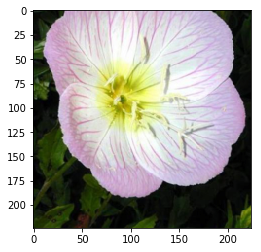

In [15]:
image_dir = data_dir + "/test" + "/1" + "/image_06743.jpg"
image_test = process_image(image_dir)
imshow(image_test, ax=None, title=None)

# Part 8: Class Prediction

Once we can get the images in the correct format, it's time to write a function for making predictions with our model. A common practice is to predict the top 5 or so (usually called top-K) most probable classes. I will calculate the class probabilities then find the K largest values.

To get the top K largest values in a tensor, I will use [`x.topk(k)`](http://pytorch.org/docs/master/torch.html#torch.topk). This method returns both the highest `k` probabilities and the indices of those probabilities corresponding to the classes. I will later convert these indices to the actual class labels using `class_to_idx` which we added to the model earlier.

This method should take a path to an image and a model checkpoint, then return the probabilities and classes.

```python
probs, classes = predict(image_path, model)
print(probs)
print(classes)
> [ 0.01558163  0.01541934  0.01452626  0.01443549  0.01407339]
> ['70', '3', '45', '62', '55']
```

In [16]:
def predict(image_path, model, topk=5):
    """ 
    Predict the class (or classes) of an image using a trained deep learning model.
    """
    img_torch = process_image(image_path)
    
    # converting from np array to pytorch tensor again
    # because nparray object has no unsqueeze method
    img_torch = torch.from_numpy(img_torch).type(torch.FloatTensor)
    
    # adjusting the dimensions
    img_torch = img_torch.unsqueeze_(0)
    img_torch = img_torch.float()
    
    with torch.no_grad():
        output = model.forward(img_torch.cuda())

    probability = F.softmax(output.data, dim=1)
    
    return probability.topk(topk)

    # Setting model to evaluation mode and turning off gradients
    loaded_model.eval()
    with torch.no_grad():
        # Running image through network
        output = loaded_model.forward(img_add_dim)

    # Calculating probabilities
    probs = torch.exp(output)
    probs_top = probs.topk(topk)[0]
    index_top = probs.topk(topk)[1]
    
    # Converting probabilities and outputs into lists
    probs_top_list = np.array(probs_top)[0]
    index_top_list = np.array(index_top[0])
    
    # Getting indixes and classes
    class_to_idx = loaded_model.class_to_idx
    indx_to_class = {x: y for y, x in class_to_idx.items()}

    # Converting index list to class list
    classes_top_list = []
    for index in index_top_list:
        classes_top_list += [indx_to_class[index]]
        
    return probs_top_list, classes_top_list

test_image_dir = data_dir + "/test" + "/38" + "/image_05833.jpg"
probabilities, classes = predict(test_image_dir, model)
print(probabilities)
print("-"*72)
print(classes)

tensor([[ 0.5408,  0.3991,  0.0293,  0.0137,  0.0071]], device='cuda:0')
------------------------------------------------------------------------
tensor([[ 34,  94,  17,  65,   2]], device='cuda:0')


In [17]:
def predict(image_path, model, topk=5):
    """
    Predict the class (or classes) of an image using a trained deep learning model.
    """
    # Having an error with the GPUs atm, so switching to cpu for this
    model_loaded = load_checkpoint(model).cpu()
    image = process_image(image_path)
    
    # from tensor to nparray
    image_to_tensor = torch.from_numpy(image).type(torch.FloatTensor)
    image_dim_u = image_to_tensor.unsqueeze_(0)

    model_loaded.eval()
    with torch.no_grad():
        output = model_loaded.forward(image_dim_u)

    probabilities = torch.exp(output)
    probabilities_topk = probabilities.topk(topk)[0]
    indexes_topk = probabilities.topk(topk)[1]
    
    probabilities_topk_list = np.array(probabilities_topk[0])
    indexes_topk_list = np.array(indexes_topk[0])
    
    class_to_idx = model_loaded.class_to_idx
    # we are accessing the names of the classes using their key values
    idx_to_class = {y: x for x, y in class_to_idx.items()}

    # indexes_topk_list -> classes_topk_list
    classes_topk_list = []
    for index in indexes_topk_list:
        classes_topk_list += [idx_to_class[index]]
        
    return probabilities_topk_list, classes_topk_list

# Part 9: Sanity Checking

Now that we can use a trained model for predictions, let's see whether our model makes sense. Even if the testing accuracy is high, it's always good to check that there aren't obvious bugs. I will use `matplotlib` to plot the probabilities for the top 5 classes as a bar graph, along with the input image. It should look like this:

<img src='images/inference_example.png' width=300px>

We can convert from the class integer encoding to actual flower names with the `cat_to_name.json` file (should have been loaded earlier in the notebook). To show a PyTorch tensor as an image, use the `imshow` function defined above.

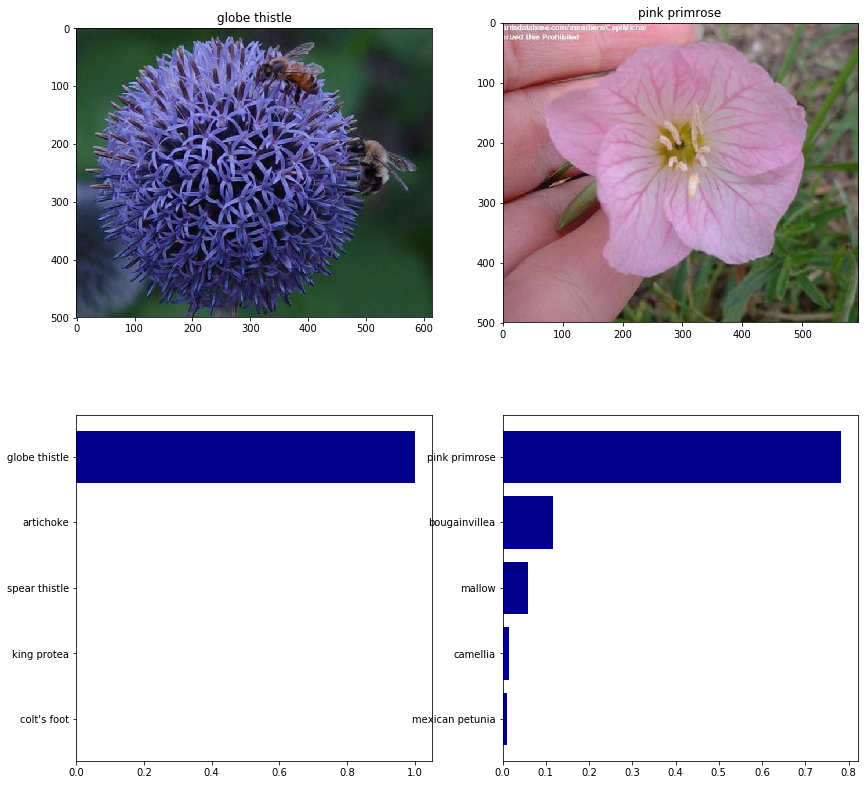

In [21]:
# Display an image along with the top 5 classes
model_dir = 'checkpoint.pth'
test_image1_dir = data_dir + "/test" + "/10" + "/image_07090.jpg"
test_image2_dir = data_dir + "/test" + "/1" + "/image_06754.jpg"

# Getting the probabilities and classes once more
probabilities1, classes1 = predict(test_image1_dir, model_dir, topk=5)
probabilities2, classes2 = predict(test_image2_dir, model_dir, topk=5)

names1 = []
for i in classes1:
    names1 += [cat_to_name[i]]
    
names2 = []
for i in classes2:
    names2 += [cat_to_name[i]]

image1 = Image.open(test_image1_dir)
image2 = Image.open(test_image2_dir)

fig, ax = plt.subplots(2,2, figsize=(14,14))

ax[0,0].imshow(image1)
ax[0,0].set_title(cat_to_name[str(10)]);

ax[0,1].imshow(image2)
ax[0,1].set_title(cat_to_name[str(1)]);

y_names1 = np.arange(len(names1))
ax[1,0].barh(y_names1, probabilities1, color='darkblue')
ax[1,0].set_yticks(y_names1)
ax[1,0].set_yticklabels(names1)
ax[1,0].invert_yaxis() 

y_names2 = np.arange(len(names2))
ax[1,1].barh(y_names2, probabilities2, color='darkblue')
ax[1,1].set_yticks(y_names2)
ax[1,1].set_yticklabels(names2)
ax[1,1].invert_yaxis() 

# End

Thank you for your interest in this notebook. I completed this project on July 10, 2019 as a part of [Udacity](https://www.udacity.com/)'s [Intro to Machine Learning Nanodegree](https://www.udacity.com/course/machine-learning-engineer-nanodegree--nd009t).